In [1]:
#import libraries
import os
from PIL import Image as PImage
import matplotlib.pyplot as plt 
from skimage import io, color
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from timeit import default_timer as timer
import pandas as pd
import csv
import urllib.request
import tarfile
import random
from IPython.display import clear_output

In [2]:
def chopnb(expr, *, max=10**-10): #defining chop function to reduce very small values to 0 in arrays
    return [i if abs(i) > max else 0 for i in expr]

def abbs(expr): #defining abs function for arrays
    return [abs(i) for i in expr]

def faulty(args):      # We had faulty images in our dataset, so we wrote a function to determine if an image is faulty
    dev = np.zeros(4)  # A faulty image had same colour vertical stripes in the first 20. rows or colums and the last 110-128 rows or colums
    val = np.zeros(4)  # the algorithm works by calculating the deviation of each vertical or horizontal stripe, and summing the deviations up
    err = 5                  # We check on the first 5 pixels if stripes exist
    errp = args.shape[1]-err #and on the last 5 pixels
    for i in range(args.shape[1]):
        for j in range(3):
            val[0] = np.std(args[errp:,i,j]) # This is the i-th column pixels from 110:i to 128:i and the j.th value (L,A,B)
            val[1] = np.std(args[:err,i,j])
            val[2] = np.std(args[i,errp:,j])
            val[3] = np.std(args[i,:err,j])
            
            chopnb(val) # I needed to add a small activation limit because std gives small numbers (e-15) for a list
            dev += val  #even if it contains the same elements (numerical error during calculation)    

    if (dev[0] != 0 and dev[1] != 0 and dev[2] != 0 and dev[3] != 0): #if the 0-err (0-5) and the errp-lastpixel (123-128) pixelrange does not contain stripes then:
        return 0
    else:
        return 1
    
def cropmid(img): #function to crop a picture to a square shape, with cropping the edges, and getting the middle back
    if(img.size[0]!= img.size[1]): #check if img needs cropping in the first place
        xfrom = int((img.size[0]-min(img.size))/2) # we crop from here
        xto = xfrom+min(img.size)                  #til here
        yfrom = int((img.size[1]-min(img.size))/2)
        yto = yfrom+min(img.size)
    
        return img.crop((xfrom,yfrom,xto,yto))
    else:
        return img

In [0]:
lastPercent = -1
def dlProgress(count, blockSize, totalSize):
    global lastPercent
    percent = int(count*blockSize*100/totalSize)
    if percent != lastPercent:
        lastPercent = percent        
        clear_output()
        print(percent, '%')

#download dataset
urllib.request.urlretrieve("https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar", "data.tar", dlProgress)

100 %


('data.tar', <http.client.HTTPMessage at 0x7f2ebe620be0>)

In [3]:
#extract dataset
tar = tarfile.open("data.tar")
tar.extractall()
tar.close()

In [4]:
def dataprep():
    path = "imdb_crop/" #image folders directory
    folderList = os.listdir(path)         #list of subfolders (names)
    imagesList = []
    for folder in folderList:          #list of images in subfolder
        if not '.' in folder:          # if it's not a file
            imagesList.append(os.listdir(path+folder))

    pix = []      # array to store output lab pictures
    outsize = 128 # size of output pictures
    rgbp=[]       # array to store output RGB pictures
    cc = 0        # image count
    limit = 10**4 # max number of images to load
    start = timer()
    tm = start

    for z in range(len(imagesList)):
        for image in imagesList[z]:
            img = PImage.open(path + folderList[z] + "/" + image) # open image
            if (img.size[0]>=outsize and img.size[1]>=outsize and img.format == 'JPEG'): # check if size exceeds 128x128 because we dont want to upscale images
                img = cropmid(img).resize((outsize,outsize),resample=PImage.LANCZOS) # scale down image
                img = np.array(img.convert('RGB')) # change to np array from PIL.Image, we need the RGB conversion here to get array from pixel value tuple
                labp= np.round(color.rgb2lab(img))  # Convert image to LAB color-space
                if (faulty(labp)==0 and np.sum(abbs(labp[:,:,1]))+np.sum(abbs(labp[:,:,2])) > 3*outsize**2): # Check if image is faulty or greyscale, if not load it into our data list, should implement something here to solve limited RAM problem
                    rgbp.append(img)
                    pix.append(labp)
                    cc += 1
                    if (cc % 100 == 0):
                        prev = tm
                        tm = timer()
                        print(cc, "done, batch process time:",tm-prev)
                    if (cc >= limit):
                        end = timer()
                        print("Data preprocessing time:", end - start)
                        return rgbp, pix
                
rgbp, pix = dataprep()


100 done, batch process time: 7.3387730304315495
200 done, batch process time: 6.916361283894935
300 done, batch process time: 6.034536667265945
400 done, batch process time: 7.632795648145077
500 done, batch process time: 6.74563040376167
600 done, batch process time: 5.1271229861420835
700 done, batch process time: 7.734595051322174
800 done, batch process time: 5.729896976391473
900 done, batch process time: 7.067043203107588
1000 done, batch process time: 7.146894431342581
1100 done, batch process time: 7.115840750466688
1200 done, batch process time: 6.4423691746769975
1300 done, batch process time: 6.191064285550183
1400 done, batch process time: 6.443639693427187
1500 done, batch process time: 7.382844787755161
1600 done, batch process time: 6.099883049551337
1700 done, batch process time: 6.298229478879449
1800 done, batch process time: 6.0721055857970185
1900 done, batch process time: 6.481983540874495
2000 done, batch process time: 7.789291904600233
2100 done, batch process t

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


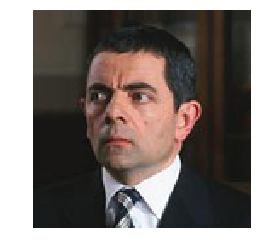

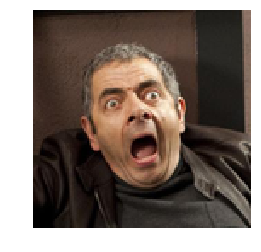

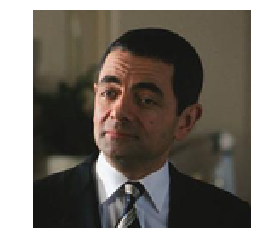

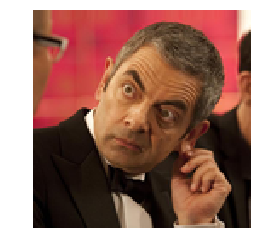

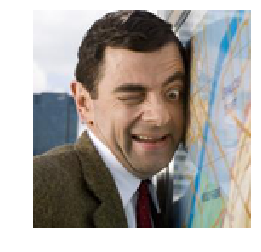

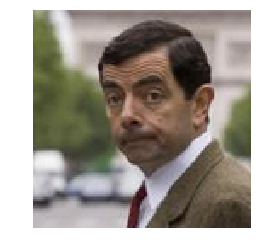

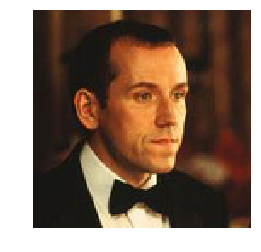

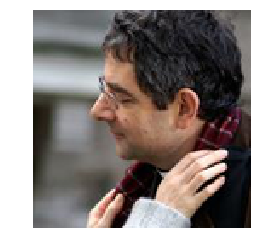

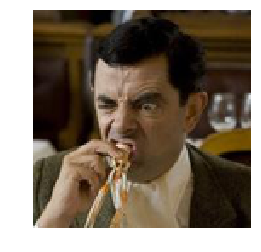

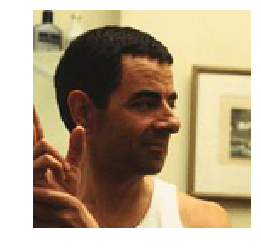

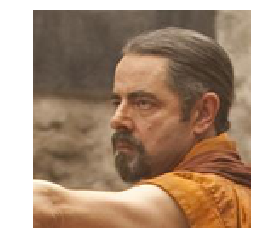

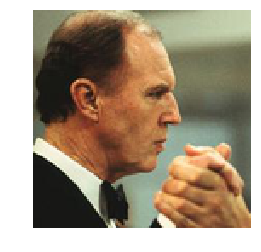

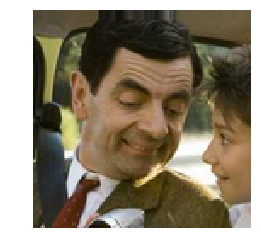

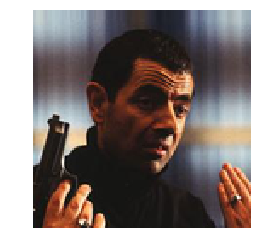

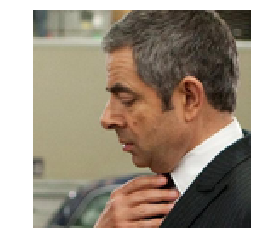

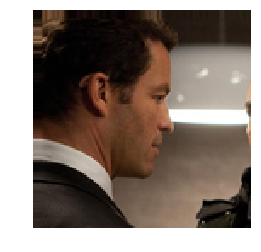

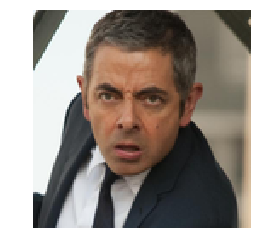

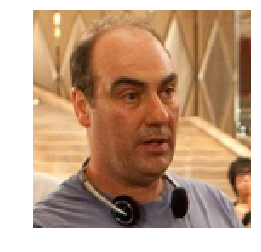

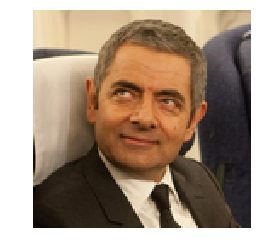

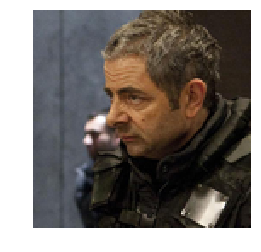

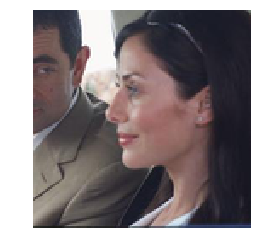

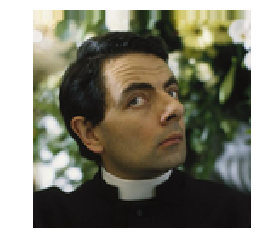

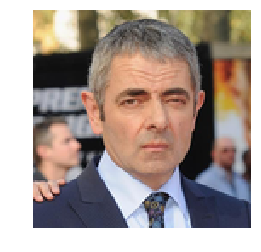

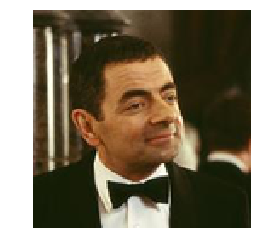

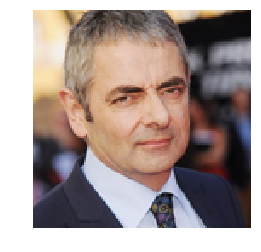

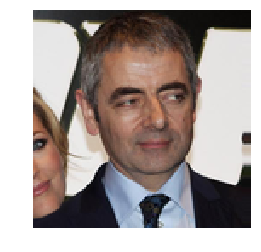

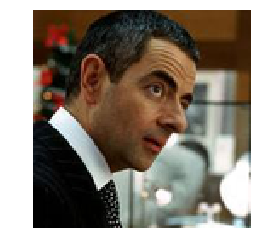

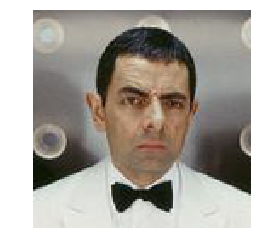

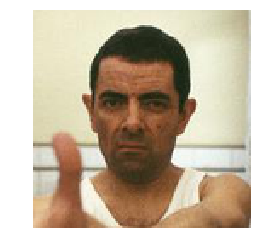

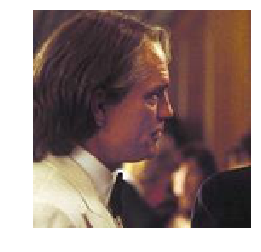

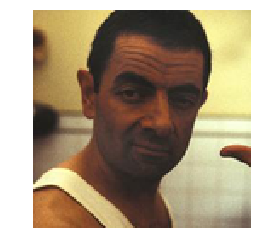

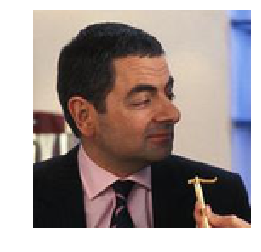

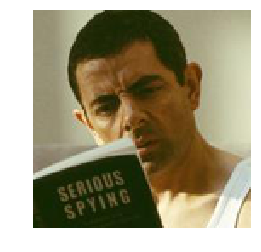

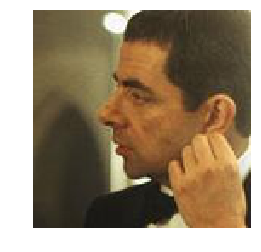

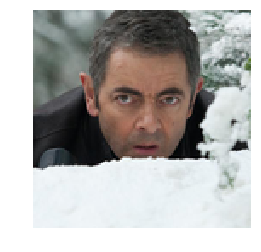

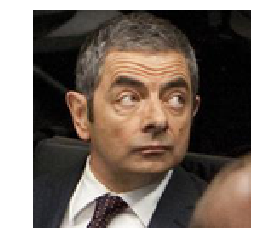

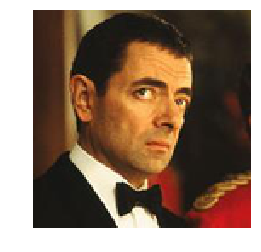

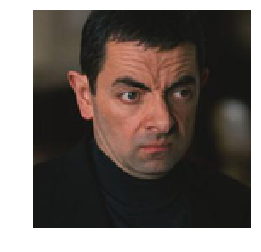

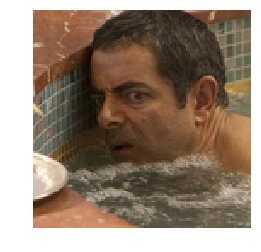

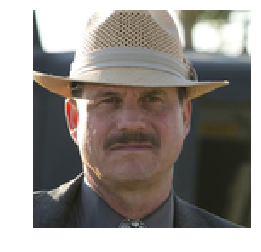

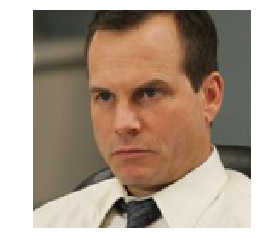

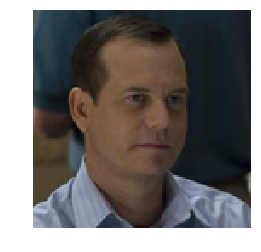

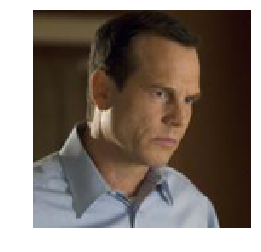

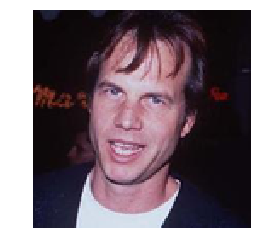

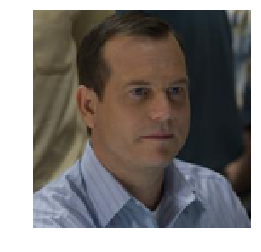

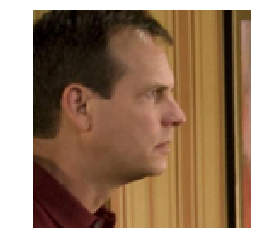

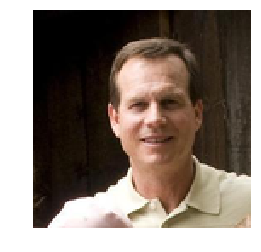

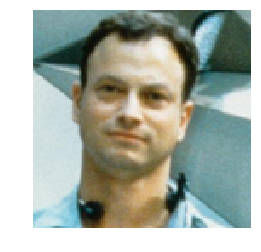

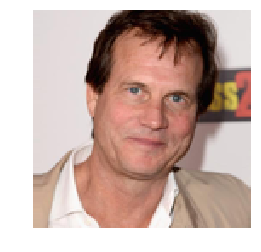

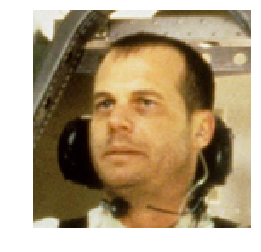

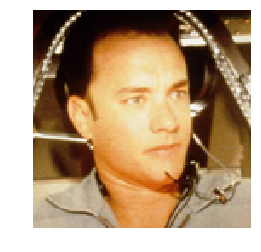

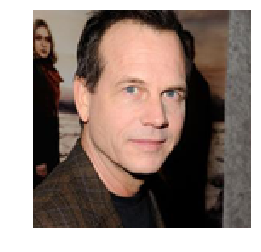

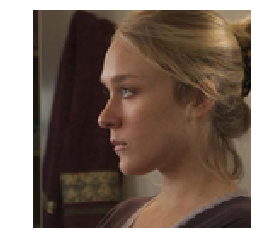

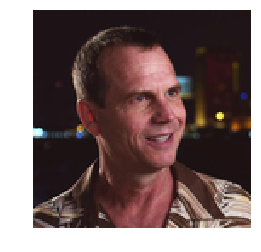

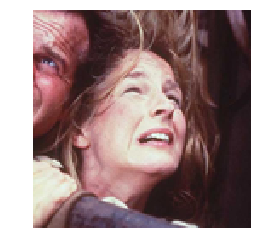

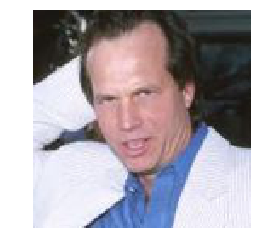

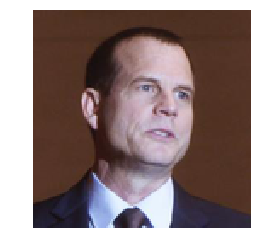

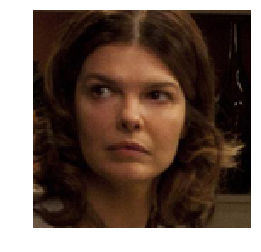

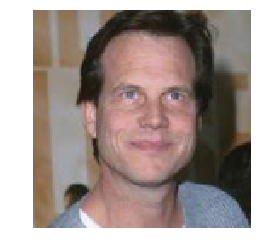

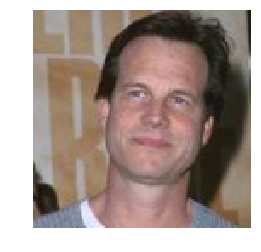

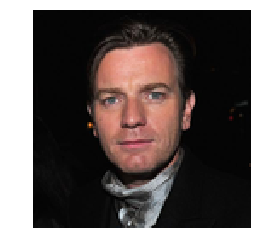

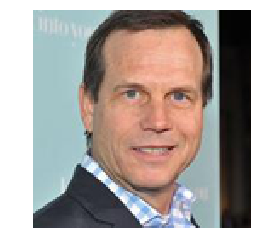

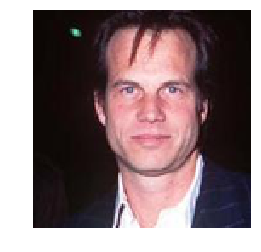

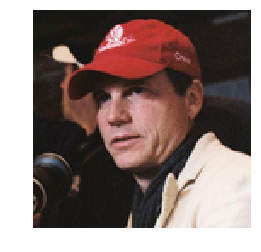

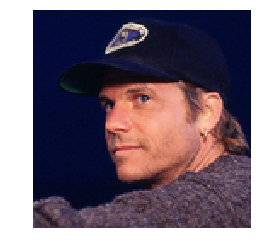

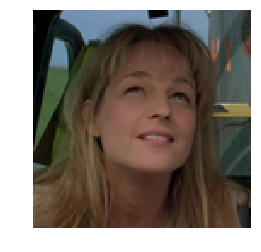

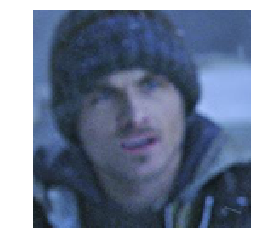

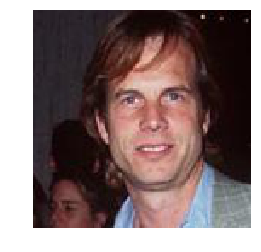

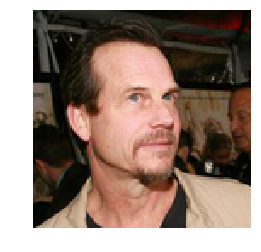

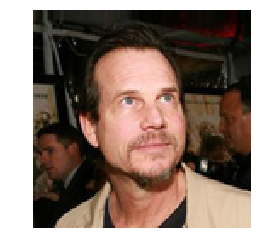

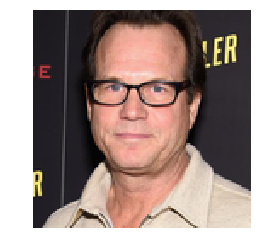

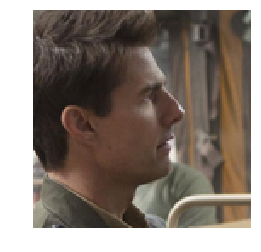

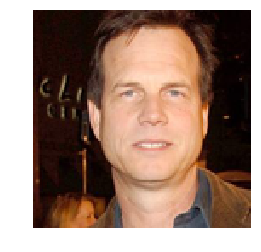

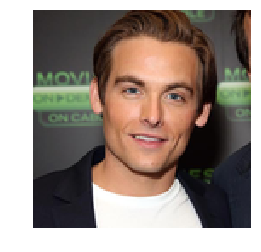

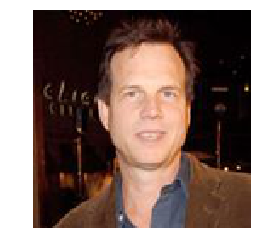

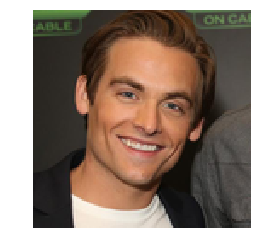

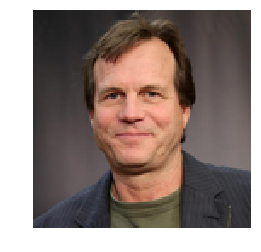

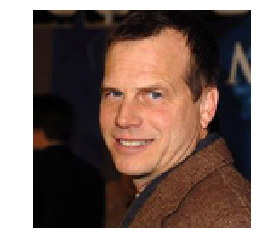

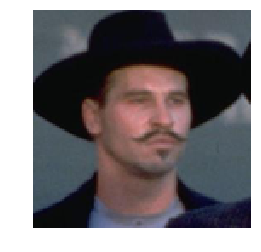

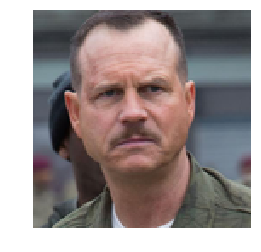

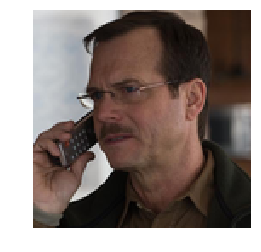

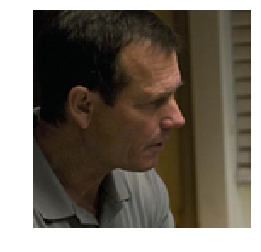

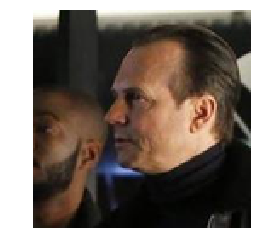

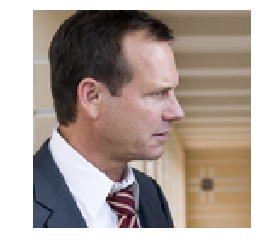

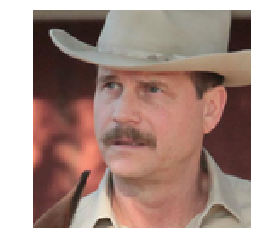

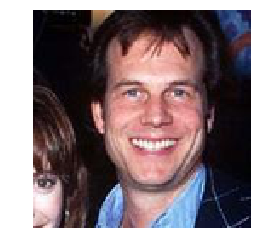

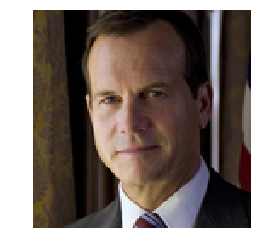

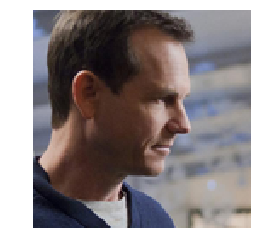

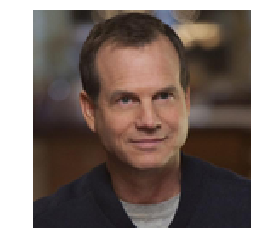

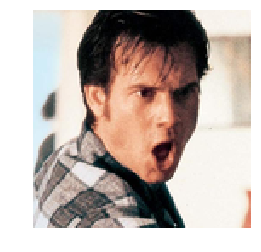

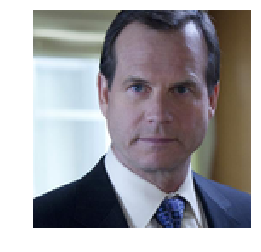

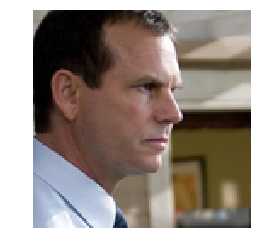

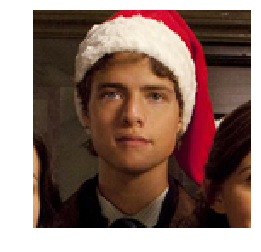

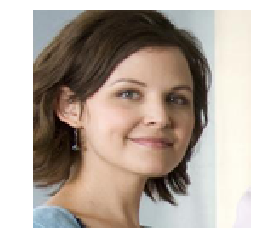

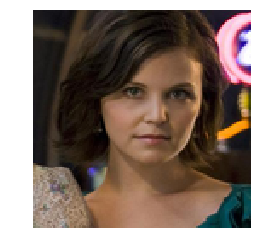

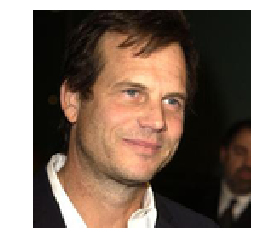

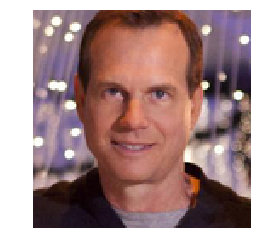

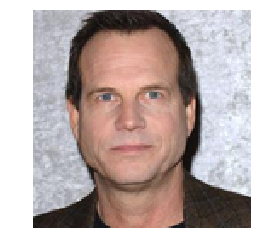

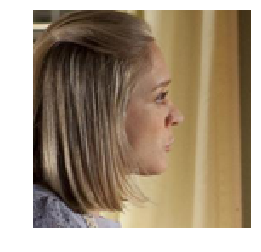

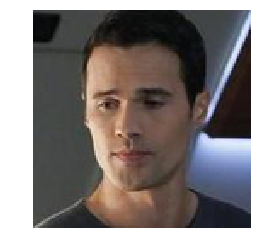

In [5]:
# demo of our data
for ind in range(100):
    plt.figure()
    plt.grid(False) # no grid
    plt.axis('off') # no axes
    plt.imshow(rgbp[ind])

In [6]:
if not os.path.exists('data'):
    os.makedirs('data')

# write the pictures array to csv, so we have a backup
with open('data/labpics.csv', 'w+',newline='') as out:
    writer = csv.writer(out, delimiter = ',')
    for ind in range(len(pix)):
        writer.writerows(np.round(np.concatenate((pix[ind][:,:,0], \
            pix[ind][:,:,1], pix[ind][:,:,2]), axis = 1)).astype(np.int))

In [16]:
# read csv fast with pandas
data = pd.read_csv('data/labpics.csv', header=None, dtype = np.float32).values # convert to numpy array
data

array([[31., 31., 30., ...,  4.,  4.,  3.],
       [31., 31., 30., ...,  4.,  4.,  3.],
       [31., 31., 30., ...,  4.,  4.,  3.],
       ...,
       [67., 44., 57., ...,  3.,  3.,  3.],
       [58., 57., 76., ...,  3.,  3.,  2.],
       [60., 72., 75., ...,  3.,  3.,  1.]], dtype=float32)

In [17]:
def create_learning_data(data, train_split = 0.7, valid_split = 0.2, test_split = 0.1):
    
    summa = train_split + valid_split + test_split  #(for safety), only the proportion of the splits matter
    train_split /= summa
    valid_split /= summa
    test_split /= summa
    
    num_pics = len(data[:,0])//128 #number of pictures (// returns int instead of float)
    
    #create blank datas
    train_data = np.zeros((int(num_pics*train_split)*128,384))
    valid_data = np.zeros(((int(num_pics*(train_split+valid_split))-int(num_pics*train_split))*128,384))
    test_data = np.zeros(((num_pics - int(num_pics*(train_split+valid_split)))*128,384))
    
    random.seed(123)
    indexes = list(range(num_pics))  
    random.shuffle(indexes)
  
    #shuffle and split data
    for i in range(num_pics):
        if i < int(num_pics*train_split):
            train_data[i*128:(i+1)*128,:] = data[indexes[i]*128:(indexes[i]+1)*128,:]
        elif i < int(num_pics*(train_split+valid_split)):
            delta = int(num_pics*train_split)
            valid_data[(i-delta)*128:(i-delta+1)*128,:] = data[indexes[i]*128:(indexes[i]+1)*128,:]
        else:
            delta = int(num_pics*(train_split+valid_split))
            test_data[(i-delta)*128:(i-delta+1)*128,:] = data[indexes[i]*128:(indexes[i]+1)*128,:]
    
    # input normalizer
    train_data[:,0:128] = train_data[:,0:128]/100
    valid_data[:,0:128] = valid_data[:,0:128]/100
    test_data[:,0:128] = test_data[:,0:128]/100
    
    # output normalizer
    train_data[:,128:] = (train_data[:,128:]+128)/255
    valid_data[:,128:] = (valid_data[:,128:]+128)/255
    test_data[:,128:] = (test_data[:,128:]+128)/255
                  
    return train_data, valid_data, test_data

#save 2d data in .csv
def array2csv(array, file):
    with open(file, 'w+',newline='') as out:
        writer = csv.writer(out, delimiter = ',')       
        writer.writerows(array)

# this function helps to refer a picture's values
# it doesn't copy any data
def rearrange(data, im_w = 128, im_h = 128):
    arranged_data = []
    for i in range(data.shape[0]//im_h): # iterating in all pictures
        arranged_data.append([data[i*im_h:(i+1)*im_h,0:im_w], # L channel
                              data[i*im_h:(i+1)*im_h,im_w:2*im_w], # a channel
                              data[i*im_h:(i+1)*im_h,2*im_w:]]) # b channel
    return arranged_data #the form is: arrenged_data[picture][channel] (type: numpy.ndarray)

#visualizzation - shows all channels of  an image in LAB color space
def lab_show(img):
    plt.figure
    plt.rcParams["figure.figsize"] = [15,10] # bigger plot size
    #creating color map from L = 0 to L = 100
    cmL = LinearSegmentedColormap.from_list('L channel', [(0, 0, 0), (1, 1, 1)], N=101)
    plt.subplot(131) # 1 row, 3 columns, 1st figure
    plt.title('L channel')
    plt.grid(False) # no grid
    plt.axis('off') # no axes
    plt.imshow(img[0], cmap=cmL, vmin = 0, vmax = 100)
    # creating color map from a = -128 to a = +127
    # note: color map values are just for visualization
    cmA = LinearSegmentedColormap.from_list('a channel', [(0.153, 0.922, 0.722), (1, 0, 0.392)], N=2550)
    plt.subplot(132) # 1 row, 3 columns, 2nd figure
    plt.title('A channel')
    plt.grid(False) # no grid
    plt.axis('off') # no axes
    plt.imshow(img[1], cmap=cmA, vmin = -128, vmax = 127)
    
    # creating color map from b = -128 to a = +127
    # note: color map values are just for visualization
    cmB = LinearSegmentedColormap.from_list('b channel', [(0, 0, 1), (1, 0.902, 0)], N=255)
    plt.subplot(133) # 1 row, 3 columns, 3rd figure
    plt.title('B channel')
    plt.grid(False) # no grid
    plt.axis('off') # no axes
    plt.imshow(img[2], cmap=cmB, vmin = -128, vmax = 127)
    plt.show()

def outputscaler(img): #function to upscale our image for the excel output, the plt.imshow() finction does not need upscaling
    #funtcion of min-max scaling: y = (x-min(x))/(max(x)-min(x)), we need to reverse this: x = y*(max(x)-min(x)) + min(x)
    ret = []
    ret.append(np.round(img[0]*100))     #L channel goes from 0 - +100
    ret.append(np.round((img[1]*255))-128) #a channel goes from -128 to +127
    ret.append(np.round((img[2]*255))-128) #b channel goes from -128 to +127
    return ret

In [18]:
train_d , valid_d, test_d = create_learning_data(data)

In [19]:
# save data
path2 = "data/" #learning data directory
array2csv(train_d, path2 + 'train.csv')
array2csv(valid_d, path2 + 'valid.csv')
array2csv(test_d, path2 + 'test.csv')

In [20]:
# read learning data back with pandas
train_d = pd.read_csv(path2 + 'train.csv', header=None, dtype = np.float32).values # convert to numpy array
valid_d = pd.read_csv(path2 + 'valid.csv', header=None, dtype = np.float32).values # convert to numpy array
test_d = pd.read_csv(path2 + 'test.csv', header=None, dtype = np.float32).values # convert to numpy array

In [21]:
train_ar = rearrange(train_d)
valid_ar = rearrange(valid_d)
test_ar = rearrange(test_d)

Train data demo:


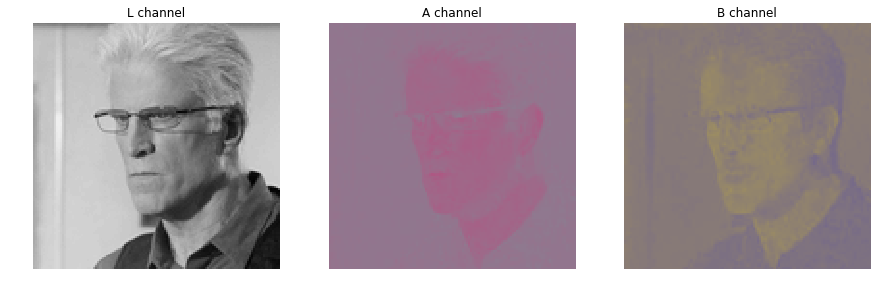

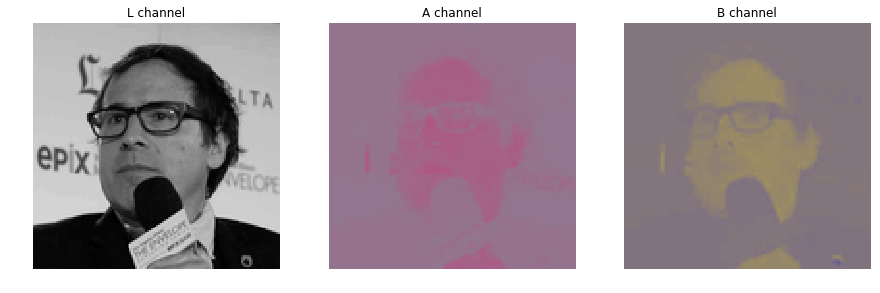

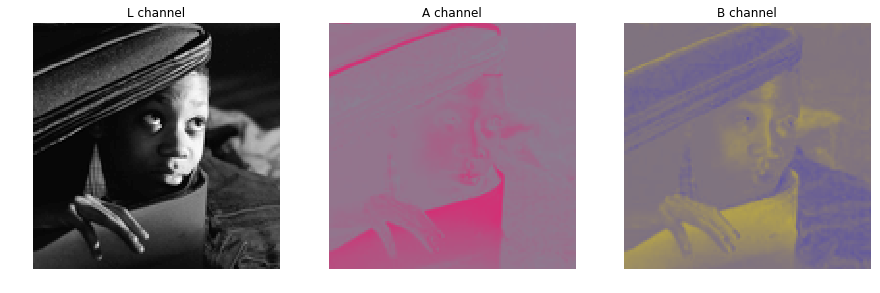

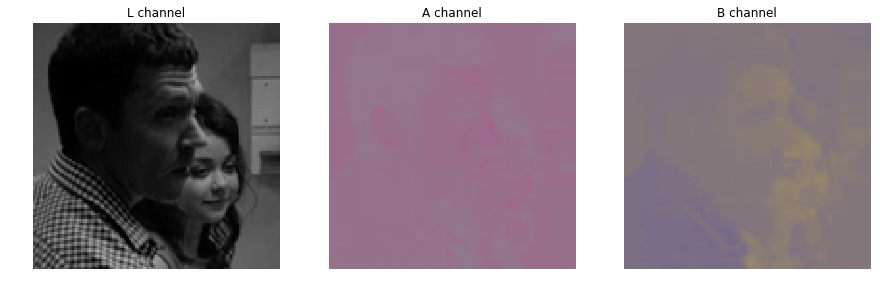

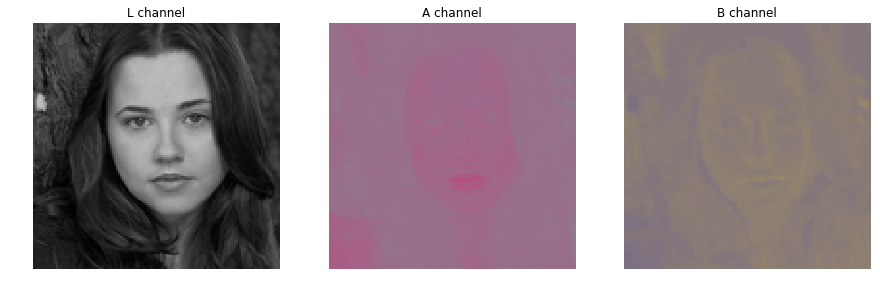

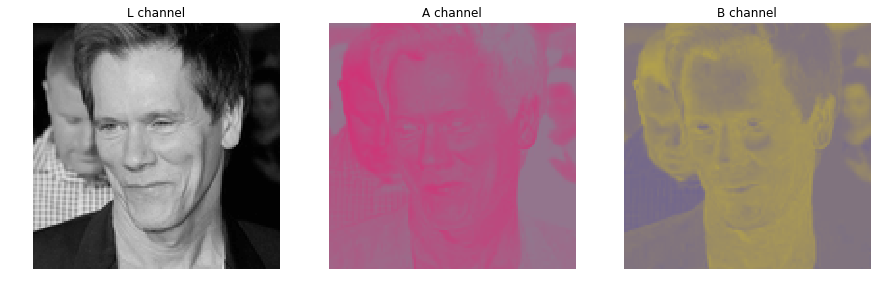

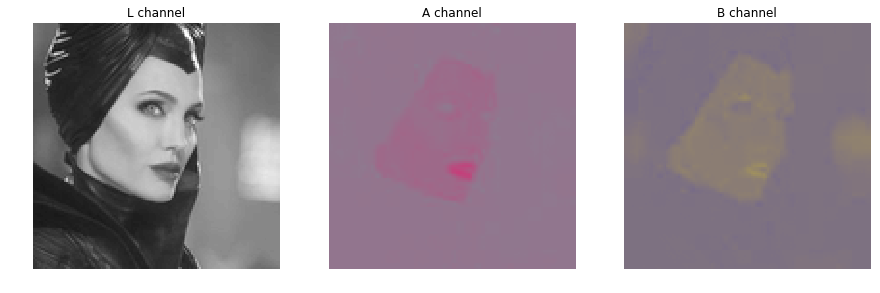

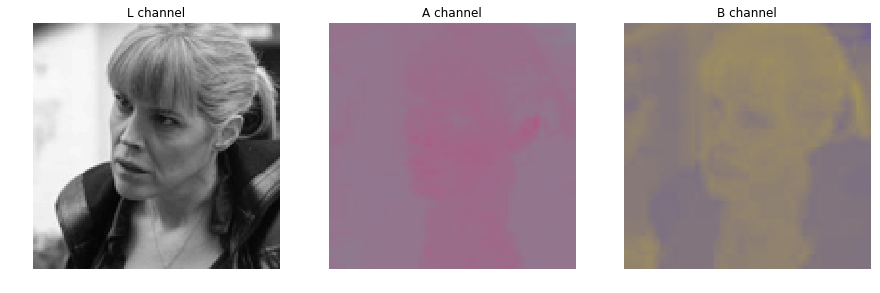

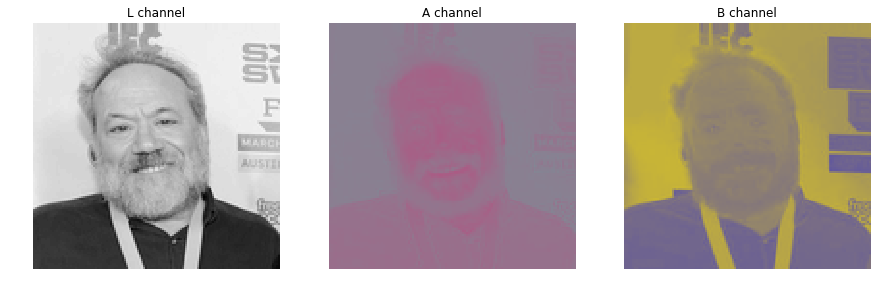

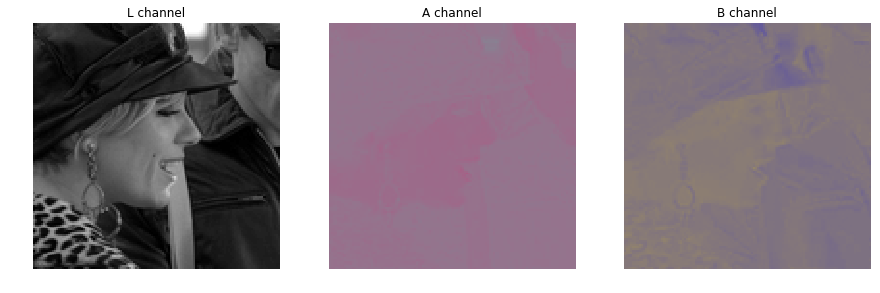

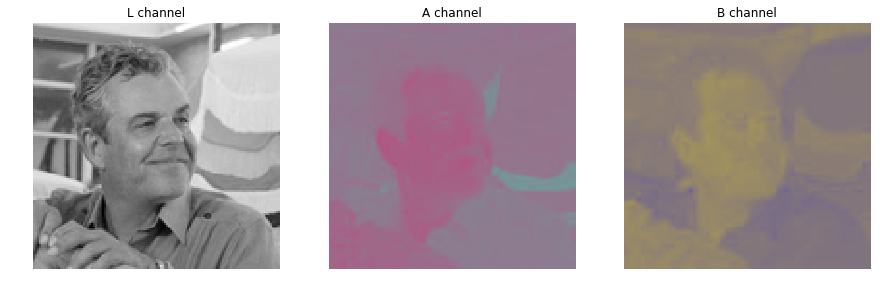

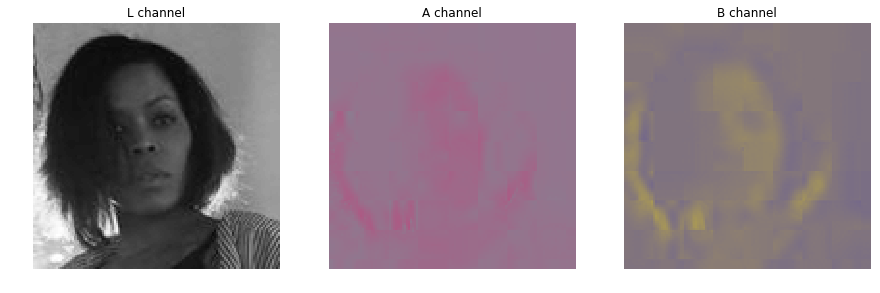

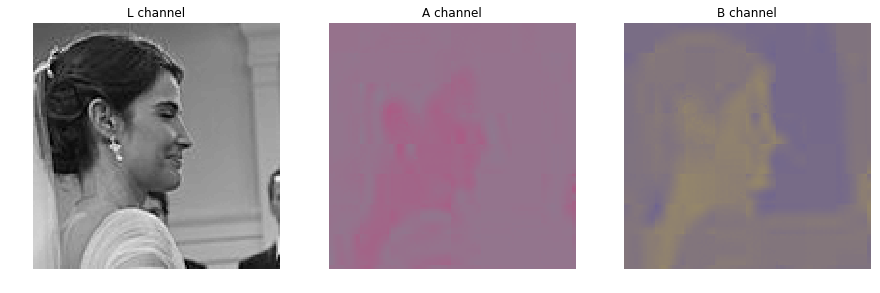

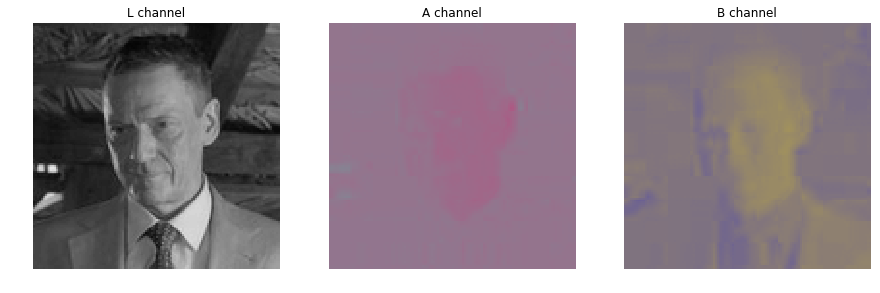

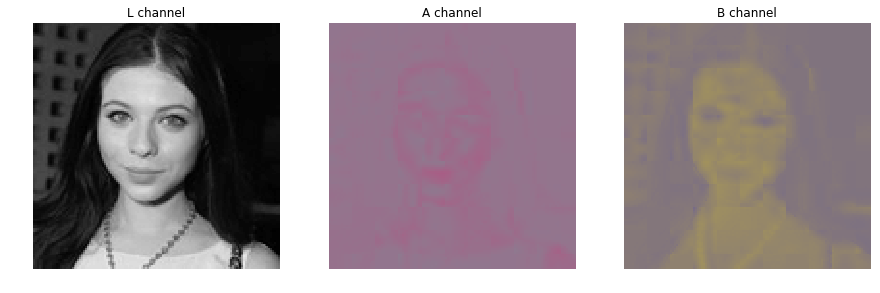

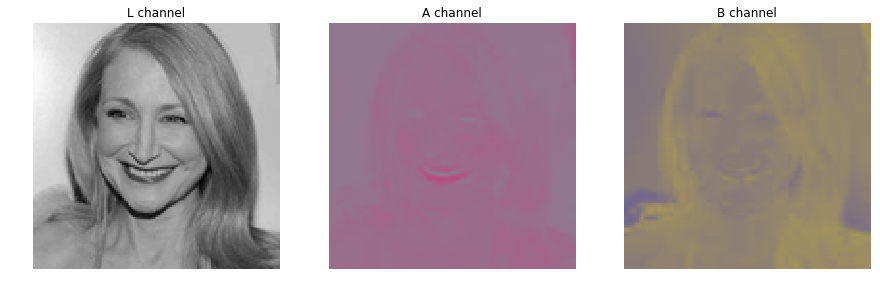

Validation data demo:


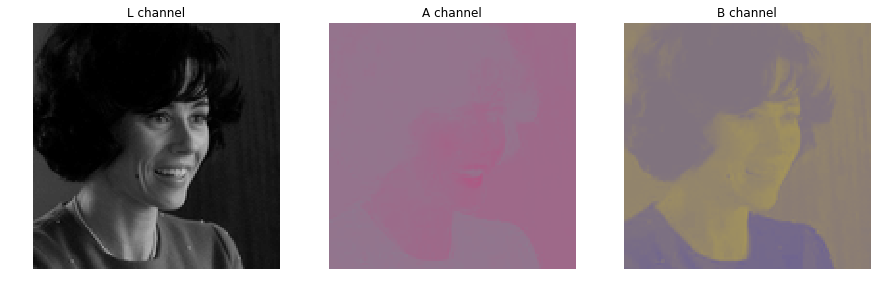

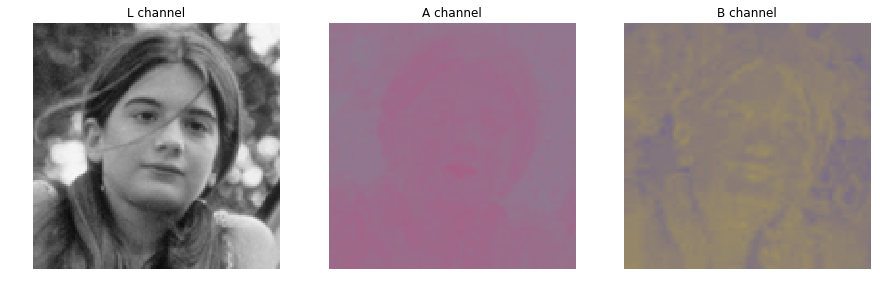

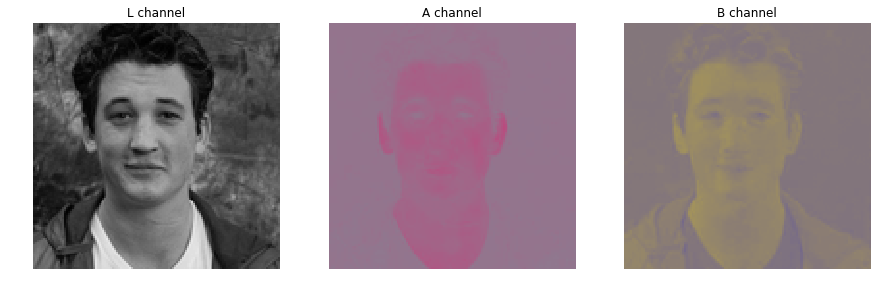

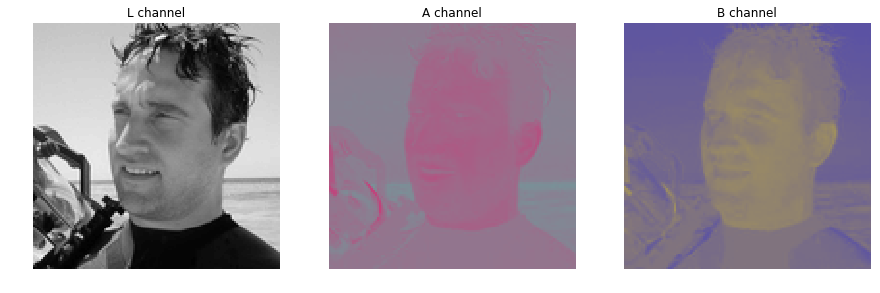

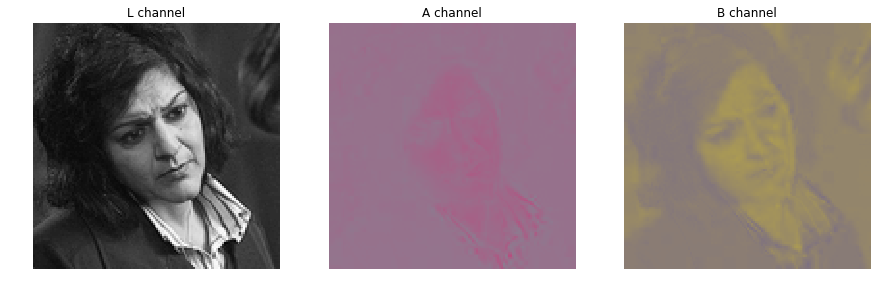

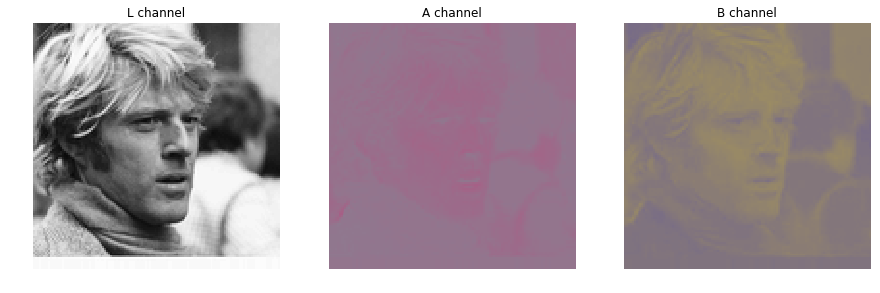

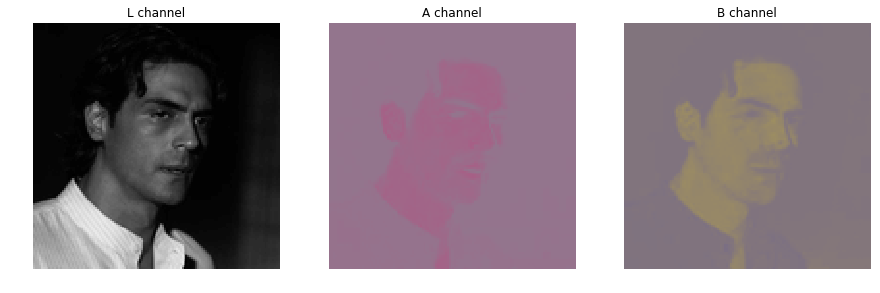

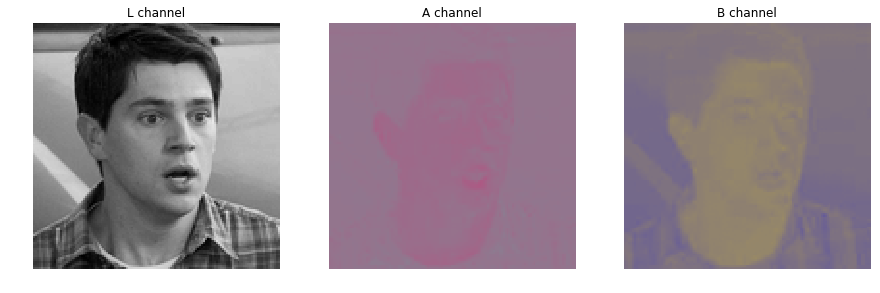

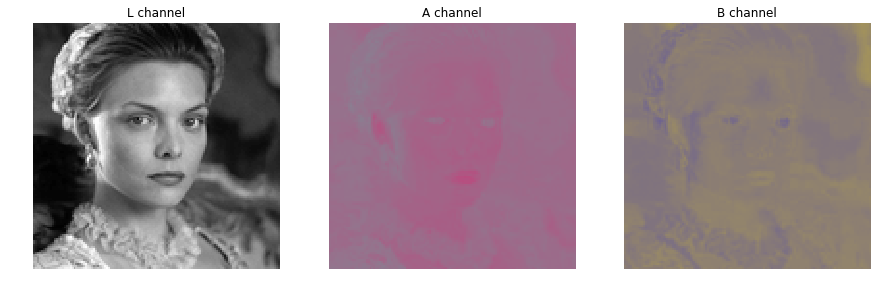

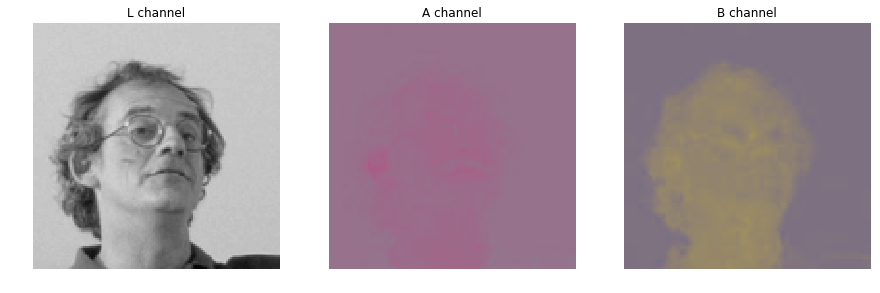

Test data demo:


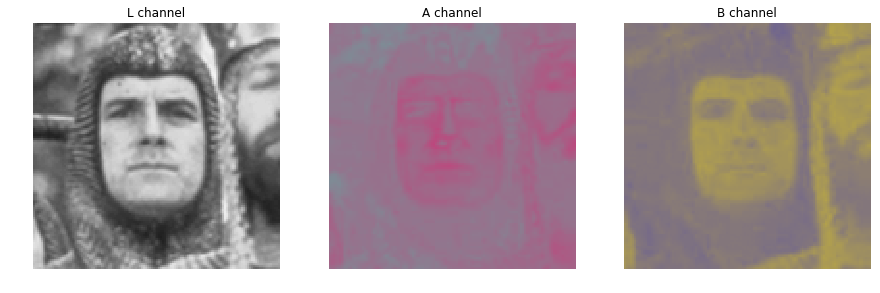

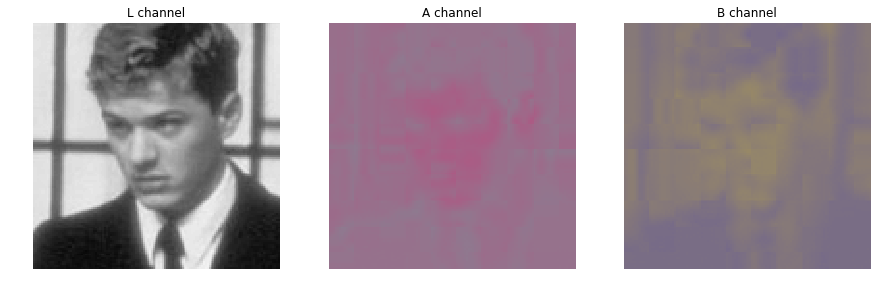

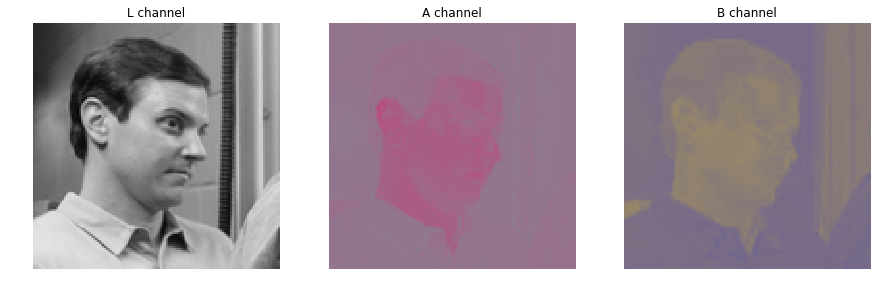

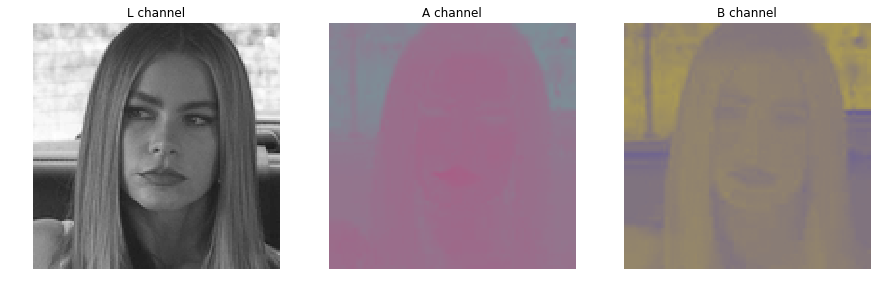

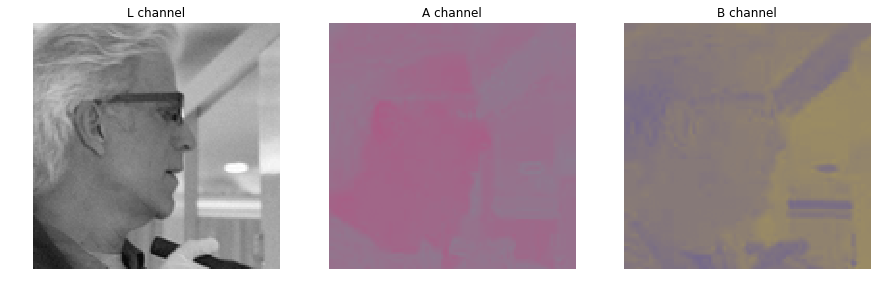

In [22]:
# demo from our learning datas
print('Train data demo:')
for ind in range(0,len(train_ar),len(train_ar) // 15):
    lab_show(outputscaler(train_ar[ind]))
print('Validation data demo:')
for ind in range(0,len(valid_ar),len(valid_ar) // 10):
    lab_show(outputscaler(valid_ar[ind]))
print('Test data demo:')
for ind in range(0,len(test_ar),len(test_ar) // 5):
    lab_show(outputscaler(test_ar[ind]))